# 데이터 전처리 

#### Library Import

In [1]:
# 한글 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import folium 
import requests
import json
import os
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 시각화 폰트 설정 
plt.rcParams['font.family'] ='NanumSquareRound'
plt.rc('font', size=20)

#### 구글드라이브 마운트 / 폴더 경로 설정

In [3]:
from google.colab import drive
drive.mount('/content/drive/') 
base_path = "drive/MyDrive/12Team/data/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 1. [서울 시민생활 데이터-행정동단위 10개 관심집단수](https://data.seoul.go.kr/dataVisual/seoul/seoulLiving.do) 데이터


In [4]:
# 서울 시민 생활 데이터 - 행정동 단위 10개 관심집단 수 (2021.01 ~ 2022.01)
df = pd.read_csv(base_path+"total_interesting.csv")
df_main = df.copy() 

### 1.1 데이터 확인 

In [5]:
print("===== 데이터프레임 확인 =====")
display(df.head())

print()
print("===== 데이터 크기 =====")
print(df.shape)

print()
print("===== 결측값 확인 =====")
print(df.isnull().sum())

===== 데이터프레임 확인 =====


,행정동코드,자치구,행정동명,성별,연령대,총인구,1인가구수,커뮤니케이션이 적은 집단,평일 외출이 적은 집단,휴일 외출이 적은 집단,출근소요시간 및 근무시간이 많은 집단,외출이 매우 적은 집단(전체),외출이 매우 많은 집단,동영상서비스 이용이 많은 집단,생활서비스 이용이 많은 집단,재정상태에 대한 관심집단,외출-커뮤니케이션이 모두 적은 집단(전체)
0,1101053,종로구,사직동,1,20,221.00,51.97,8.335199,5.796584,7.415139,5.552525,4.166128,4.89,7.638924,1.961916,3.961066,2.067203
1,1101053,종로구,사직동,1,25,321.00,109.52,11.470799,11.454176,7.532451,11.114420,4.869294,12.95,10.347566,19.109366,16.766866,2.405569
2,1101053,종로구,사직동,1,30,351.11,107.71,15.288244,15.401204,9.599103,11.075590,9.442518,20.05,14.181075,10.767105,13.375326,6.666862
3,1101053,종로구,사직동,1,35,353.00,106.53,16.389481,10.787259,7.525317,10.245072,11.536156,15.33,16.540153,9.957706,7.537253,13.037654
4,1101053,종로구,사직동,1,40,419.00,80.24,13.778743,6.035512,11.261931,5.563842,7.523350,10.97,7.483620,5.407695,8.732050,11.160781



===== 데이터 크기 =====
(111936, 17)

===== 결측값 확인 =====
행정동코드                      0
자치구                        0
행정동명                       0
성별                         0
연령대                        0
총인구                        0
1인가구수                      0
커뮤니케이션이 적은 집단              0
평일 외출이 적은 집단               0
휴일 외출이 적은 집단               0
출근소요시간 및 근무시간이 많은 집단       0
외출이 매우 적은 집단(전체)           0
외출이 매우 많은 집단               0
동영상서비스 이용이 많은 집단           0
생활서비스 이용이 많은 집단            0
재정상태에 대한 관심집단              0
외출-커뮤니케이션이 모두 적은 집단(전체)    0
dtype: int64


### 1.2 연령대 별 병합
`20대(초기청년층) - 20` /  `30대 (후기 청년층) - 30` / `40대 (중년층) - 40` / `50~64(장년층) - 50` / `65세 이상 (노년층) - 60` 으로 연령대를 병합합니다. 

In [6]:
def age_merge(x): 
  if 20 <= x < 30: 
    return 20 
  elif 20 <= x < 40: 
    return 30 
  elif 40 <= x < 50: 
    return 40
  elif 50 <= x < 65: 
    return 50 
  else: 
    return 60 

df_main["연령대"] = df_main['연령대'].apply(age_merge)

# 확인
df_main['연령대'].unique() 

array([20, 30, 40, 50, 60])

### 1.3 이상치 제거 


`외출이 매우 많은 집단`, `커뮤니케이션이 적은 집단` 컬럼에 대해서 boxplot을 그려봤을 때 평균이나 중앙값 보다 훨씬 큰 수의 데이터가 다량 있는 것으로 보입니다. 데이터 분석 및 시각화를 진행할 때 왜곡된 결과를 보일 수 있으므로, IQR 방식을 사용해서 이상치의 범위에 있는 데이터들을 삭제합니다. 

- 이상치 제거 전 boxplot 

연령대 별 병합을 진행했으므로 다시 boxplot을 그려보고 이상치를 파악한 후, 연령대별로 제거합니다. 

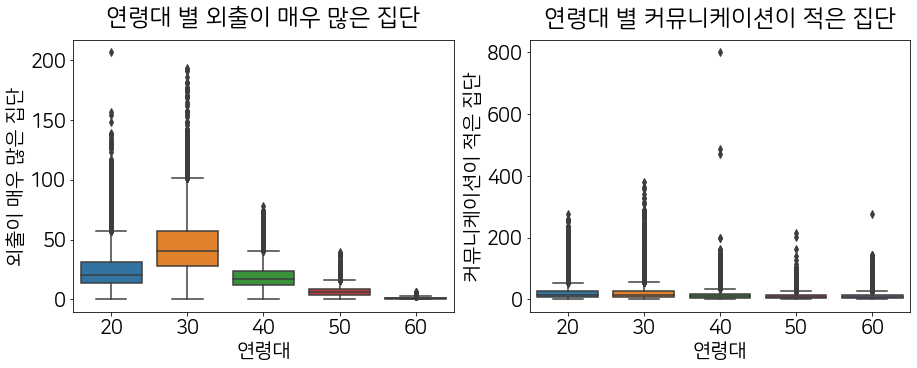

In [7]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1, 2)

ax1.set_title("연령대 별 외출이 매우 많은 집단", pad=15)
_=sns.boxplot(data=df_main, x='연령대', y="외출이 매우 많은 집단", ax=ax1)

ax2.set_title("연령대 별 커뮤니케이션이 적은 집단", pad=15)
_=sns.boxplot(data=df_main, x='연령대', y="커뮤니케이션이 적은 집단", ax=ax2)

- 외출이 매우 많은 집단 연령대 별 이상치 제거 

이상치 제거에는 IQR 방식을 사용합니다. 

In [8]:
print("원본 데이터 개수: ", df_main.size)

for age in df_main["연령대"].unique():
  df_out_age = df_main[df_main["연령대"] == age]['외출이 매우 많은 집단']
  Q1 = df_out_age.quantile(0.25)
  Q3 = df_out_age.quantile(0.75)
  IQR = Q3 - Q1

  df_out_age_outlier = df_out_age[(df_out_age >= Q3 + 1.5*IQR) | (df_out_age <= Q1 - 1.5*IQR)]
  df_main = df_main.drop(index=df_out_age_outlier.index)
  
print("이상치 제거 후 데이터 개수: ", df_main.size)

원본 데이터 개수:  1902912
이상치 제거 후 데이터 개수:  1834623


- 커뮤니케이션이 적은 집단 연령대 별 이상치 제거 

In [9]:
print("원본 데이터 개수: ", df_main.size)

for age in df_main["연령대"].unique():
  df_com_age = df_main[df_main["연령대"] == age]['커뮤니케이션이 적은 집단']
  Q1 = df_com_age.quantile(0.25)
  Q3 = df_com_age.quantile(0.75)
  IQR = Q3 - Q1

  df_com_age_outlier = df_com_age[(df_com_age >= Q3 + 1.5*IQR) | (df_com_age <= Q1 - 1.5*IQR)]
  df_main = df_main.drop(index=df_com_age_outlier.index)

print("이상치 제거 후 데이터 개수: ", df_main.size)

원본 데이터 개수:  1834623
이상치 제거 후 데이터 개수:  1731280


- 이상치 제거 후 boxplot 

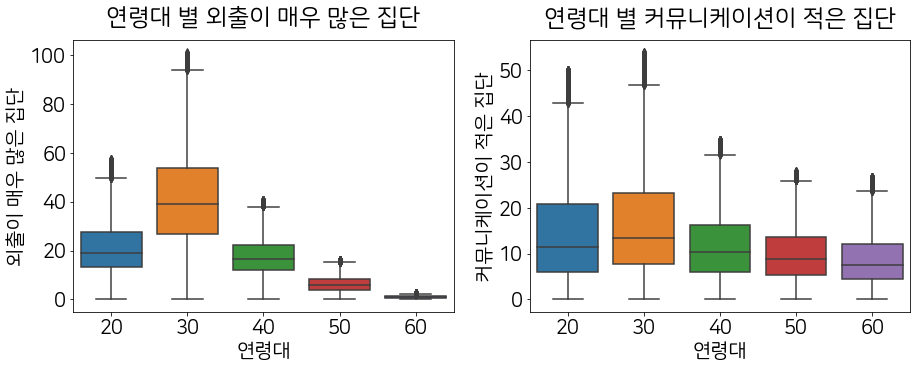

In [10]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1, 2)

ax1.set_title("연령대 별 외출이 매우 많은 집단", pad=15)
_=sns.boxplot(data=df_main, x='연령대', y="외출이 매우 많은 집단", ax=ax1)

ax2.set_title("연령대 별 커뮤니케이션이 적은 집단", pad=15)
_=sns.boxplot(data=df_main, x='연령대', y="커뮤니케이션이 적은 집단", ax=ax2)

### 1.4 스케일링
 시각화에서 같은 범위에서 비교해보기 위해 외출이 매우 많은 집단의 외출 지수와, 커뮤니케이션이 적은 집단의 커뮤니케이션 지수의 스케일을 0~1로 같게 만듭니다.  
- 생성 컬럼 명: `out_sclaed`, `com_scaled`

In [11]:
out_min, out_max = df_main["외출이 매우 많은 집단"].min(), df_main["외출이 매우 많은 집단"].max()
com_min, com_max = df_main["커뮤니케이션이 적은 집단"].min(), df_main["커뮤니케이션이 적은 집단"].max()

df_main["out_scaled"] = df_main["외출이 매우 많은 집단"].apply(lambda x: (x-out_min) / (out_max - out_min))
df_main["com_scaled"] = df_main["커뮤니케이션이 적은 집단"].apply(lambda x: (x-com_min) / (com_max - com_min))

# 확인 
print("외출이 매우 많은 집단: ", df_main["out_scaled"].min(), df_main["out_scaled"].max())
print("커뮤니케이션이 적은 집단: ", df_main["com_scaled"].min(), df_main["com_scaled"].max())

외출이 매우 많은 집단:  0.0 1.0
커뮤니케이션이 적은 집단:  0.0 1.0


## 2. [서울시 1인가구(연령별) 통계](https://data.seoul.go.kr/dataList/10995/S/2/datasetView.do) 데이터

In [12]:
# 서울시 1인가구(연령별) 통계
df_year = pd.read_excel(base_path+"1인가구_연령별.xlsx")

/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [13]:
df_year.head()

,자치구별(1),자치구별(2),2016,2016.1,2016.2,2016.3,2016.4,2016.5,2016.6,2016.7,...,2021.6,2021.7,2021.8,2021.9,2021.10,2021.11,2021.12,2021.13,2021.14,2021.15
0,자치구별(1),자치구별(2),합계,합계,합계,합계,합계,합계,합계,합계,...,합계,합계,합계,합계,합계,합계,합계,합계,합계,합계
1,자치구별(1),자치구별(2),소계,20세미만,20~24세,25~29세,30~34세,35~39세,40~44세,45~49세,...,40~44세,45~49세,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85세이상
2,자치구별(1),자치구별(2),계,계,계,계,계,계,계,계,...,계,계,계,계,계,계,계,계,계,계
3,합계,소계,1138860,14937,101069,169534,152434,107045,88976,83763,...,99293,89640,89413,86500,102413,88494,69402,57061,42020,28407
4,합계,종로구,22835,526,2973,3547,2486,1723,1497,1633,...,1690,1620,1783,1757,1864,1546,1160,1133,811,597


----------------

In [14]:
# 원본 데이터를 카피하여 사용합니다. 
df_2016_2021 = df_year.copy() 
print("df_2016_2021 shape: ", df_2016_2021.shape)
display(df_2016_2021.head())

df_2016_2021 shape:  (29, 98)


,자치구별(1),자치구별(2),2016,2016.1,2016.2,2016.3,2016.4,2016.5,2016.6,2016.7,...,2021.6,2021.7,2021.8,2021.9,2021.10,2021.11,2021.12,2021.13,2021.14,2021.15
0,자치구별(1),자치구별(2),합계,합계,합계,합계,합계,합계,합계,합계,...,합계,합계,합계,합계,합계,합계,합계,합계,합계,합계
1,자치구별(1),자치구별(2),소계,20세미만,20~24세,25~29세,30~34세,35~39세,40~44세,45~49세,...,40~44세,45~49세,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85세이상
2,자치구별(1),자치구별(2),계,계,계,계,계,계,계,계,...,계,계,계,계,계,계,계,계,계,계
3,합계,소계,1138860,14937,101069,169534,152434,107045,88976,83763,...,99293,89640,89413,86500,102413,88494,69402,57061,42020,28407
4,합계,종로구,22835,526,2973,3547,2486,1723,1497,1633,...,1690,1620,1783,1757,1864,1546,1160,1133,811,597


### 2.2 연도 별 연령 별 1인 가구 수 기본 전처리 
제공되는 데이터의 형태가 정제되어있지 않아서 데이터 분석이 가능한 형태로 전처리합니다.

- 필요 없는 열, 행 삭제 (자치구별, 소계, 합계, 계 포함된 데이터) 

In [15]:
df_2016_2021 = df_2016_2021.drop(columns=["자치구별(1)"]).drop([0, 2, 3])

- 컬럼 년도 전처리   

1행의 연령대 별로 년도 뒤에 숫자가 붙어있는 것을 삭제합니다.

In [16]:
lst_year = list(range(2016, 2022))
lst_num = list(range(1, 16))

# 연도 합계 삭제 
for year in lst_year: 
  df_2016_2021 = df_2016_2021.drop(columns=[str(year)])

# 연도 이름 통일 
for year in lst_year: 
  for num in lst_num:
    df_2016_2021 = df_2016_2021.rename(columns={f"{year}.{num}" : f'{year}'})

df_2016_2021.head()

,자치구별(2),2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
1,자치구별(2),20세미만,20~24세,25~29세,30~34세,35~39세,40~44세,45~49세,50~54세,55~59세,...,40~44세,45~49세,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85세이상
4,종로구,526,2973,3547,2486,1723,1497,1633,1544,1537,...,1690,1620,1783,1757,1864,1546,1160,1133,811,597
5,중구,567,2061,2521,2140,1595,1461,1575,1391,1482,...,1607,1486,1609,1540,1728,1567,1168,962,762,555
6,용산구,250,2591,4108,4316,3191,2771,2604,2090,2102,...,3106,2624,2451,2166,2364,1925,1466,1335,1117,899
7,성동구,878,4276,5706,4400,3225,2824,2833,2561,2548,...,3011,2773,2822,2721,3078,2464,1854,1666,1252,773


- 연령대 컬럼 처리 및 연도 컬럼 생성 

In [17]:
# 연령대 컬럼을 만들기 위해 행 따로 추출 
df_2016_2021 = df_2016_2021.rename(columns={'자치구별(2)': "자치구"})
age = df_2016_2021.loc[1]
df_2016_2021 = df_2016_2021.drop(1)
print("== 필요 없는 column, row 삭제 후 ==")
display(df_2016_2021.head() )

# 연도 컬럼 녹이기
df_melt = df_2016_2021.melt(id_vars=['자치구']).rename(columns={"variable": '연도', "value": "1인가구수"}).sort_values(by=['자치구', '연도'])

# 연령대 컬럼 추가 
df_melt['연령대'] = age.iloc[1:].values.tolist()*25

print()
print("== 연도 녹이고 연령대 추가 ==")
display(df_melt.head())

== 필요 없는 column, row 삭제 후 ==


,자치구,2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
4,종로구,526,2973,3547,2486,1723,1497,1633,1544,1537,...,1690,1620,1783,1757,1864,1546,1160,1133,811,597
5,중구,567,2061,2521,2140,1595,1461,1575,1391,1482,...,1607,1486,1609,1540,1728,1567,1168,962,762,555
6,용산구,250,2591,4108,4316,3191,2771,2604,2090,2102,...,3106,2624,2451,2166,2364,1925,1466,1335,1117,899
7,성동구,878,4276,5706,4400,3225,2824,2833,2561,2548,...,3011,2773,2822,2721,3078,2464,1854,1666,1252,773
8,광진구,805,6136,9929,8069,5156,3903,3680,3278,3292,...,4257,3554,3738,3608,3969,3023,2184,1764,1216,806



== 연도 녹이고 연령대 추가 ==


,자치구,연도,1인가구수,연령대
22,강남구,2016,572,20세미만
47,강남구,2016,3290,20~24세
72,강남구,2016,9652,25~29세
97,강남구,2016,11904,30~34세
122,강남구,2016,8747,35~39세


### 2.3 연령대 별 병합
`20세미만(미성년자) - 10` / `20대(초기청년층) - 20` /  `30대 (후기 청년층) - 30` / `40대 (중년층) - 40` / `50~64(장년층) - 50` / `65세 이상 (노년층) - 60` 으로 나누어 연령대를 병합합니다. 

In [18]:
# 20세 미만은 10대로 구분 
df_melt["연령대"] = df_melt["연령대"].str.replace("20세미만", "10")

# 연령대 분리 
df_melt['연령대'] = df_melt['연령대'].str.replace('세|이상', "").str.split("~")

def age_merge2(lst_age): 
  x = int(lst_age[0])
  if x <= 10:
    return 10 
  elif 20 <= x < 30: 
    return 20 
  elif 20 <= x < 40: 
    return 30 
  elif 40 <= x < 50: 
    return 40
  elif 50 <= x < 65: 
    return 50 
  else: 
    return 60 

df_melt["연령대"] = df_melt['연령대'].apply(age_merge2)

# 확인
df_melt['연령대'].unique() 

<ipython-input-18-ef518943cc09>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_melt['연령대'] = df_melt['연령대'].str.replace('세|이상', "").str.split("~")


array([10, 20, 30, 40, 50, 60])

## 3. [서울시 1인가구 (혼인상태별)](https://data.seoul.go.kr/dataList/10085/S/2/datasetView.do) 통계 데이터 

In [19]:
df_married = pd.read_excel(base_path + "1인가구_혼인상태별.xlsx")
df_married

,연령별(2),미혼,유배우,사별,이혼,미상
0,20세미만,14237,-,-,-,-
1,20~24세,123773,109,-,56,-
2,25~29세,236454,1467,32,564,-
3,30세~34세,175875,5174,128,2396,-
4,35세~39세,112879,7983,208,5415,-
5,40세~44세,73318,8842,280,9078,-
6,45세~49세,59791,12427,781,17187,-
7,50세~54세,41576,13300,2422,25406,-
8,55세~59세,28051,15809,7143,33973,-
9,60세~64세,18890,18116,19232,38596,-


### 3.1 연령대 별 병합 

In [20]:
def age_merge3(lst_age): 
  x = int(lst_age[0])
  if 20 <= x < 30: 
    return 20 
  elif 20 <= x < 40: 
    return 30 
  elif 40 <= x < 50: 
    return 40
  elif 50 <= x < 65: 
    return 50 
  else: 
    return 60 


df_married = df_married.rename(columns={"연령별(2)": "연령대"})[1:]
df_married["연령대"] = df_married["연령대"].str.replace("세|이상|미만| ", "").str.split("~").apply(age_merge3)

# 확인
df_married["연령대"].unique()

<ipython-input-20-27a37dba152b>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_married["연령대"] = df_married["연령대"].str.replace("세|이상|미만| ", "").str.split("~").apply(age_merge3)


array([20, 30, 40, 50, 60])

### 3.2 기타 전처리

In [21]:
df_married["사별"] = df_married['사별'].apply(lambda x: str(x).replace("-", "0"))
df_married=df_married.drop(columns=["미상"]).astype("int") # 필요 없는 컬럼 제거 
df_married_sum = df_married.groupby("연령대").sum() # 연령대 별로 그룹화
df_married_sum["사별/이혼"] = df_married_sum["사별"] + df_married_sum["이혼"] # 사별, 이혼 합치기 

df_married_per = df_married_sum[2:].append(df_married_sum[:2].sum(axis=0).to_frame().T).rename(index={0: "20대~30대"}).reset_index().rename(columns={"index": "연령대"})
df_married_per = df_married_per.astype("str")
df_married_per = df_married_per.sort_values(by='연령대').set_index("연령대").drop(columns=["사별", "이혼"])

<ipython-input-21-1ef578ddcf95>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_married_per = df_married_sum[2:].append(df_married_sum[:2].sum(axis=0).to_frame().T).rename(index={0: "20대~30대"}).reset_index().rename(columns={"index": "연령대"})


In [22]:
print(df_married_per.shape)
display(df_married_per.head())

(4, 3)


,미혼,유배우,사별/이혼
연령대,,,
20대~30대,648981,14733,8799
40,133109,21269,27326
50,88517,47225,126772
60,19073,31292,209368
